## Environment Setup

In [1]:
import os
import sys
sys.path.append("/Users/kr/Library/Python/3.11/lib/python/site-packages")
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")
# sys.path.append()
# sys.path.append()
import numpy as np
import torch.utils.data.dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dataset import get_data,normalize

from matplotlib import pyplot as plt

## Load Data

In [2]:
if __name__ == '__main__':
    ######################## Get train/test dataset ########################
    X_train, X_test, Y_train, Y_test = get_data('dataset')
    ########################################################################
    # 以上加载的数据为 numpy array格式
    # 如果希望使用pytorch或tensorflow等库，需要使用相应的函数将numpy arrray转化为tensor格式
    # 以pytorch为例：
    #   使用torch.from_numpy()函数可以将numpy array转化为pytorch tensor
    #
    # Hint:可以考虑使用torch.utils.data中的class来简化划分mini-batch的操作，比如以下class：
    #   https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
    #   https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    ########################################################################

    ########################################################################
    ######################## Implement you code below #######################
    ########################################################################

# 转换数据为Tensor格式
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

# 创建数据集
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Network Setup

In [5]:
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.bn5(x)

        x = self.fc2(x)
        x = self.relu6(x)
        x = self.bn6(x)

        x = self.fc3(x)
        
        return x

model = FashionNet()

## Training Model

In [7]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_features = []
train_labels = []

train_losses_list = []
test_losses_list = []

train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)

    # 在测试集上评估模型
    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = test_correct / len(test_dataset)

    # 打印每个epoch的训练和测试结果
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print()

    train_losses_list.append(train_loss)
    test_losses_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    # 获取中间层特征
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output1 = model.conv1(images)
            output2 = model.conv2(model.relu1(output1))
            output3 = model.conv3(model.relu2(output2))
            output4 = model.conv4(model.relu3(output3))
            intermediate_output = output4

            intermediate_output = intermediate_output.view(intermediate_output.size(0), -1)  # 重塑为(batch_size, num_channels * height * width)
            all_features.append(intermediate_output.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


Epoch 1/10
Train Loss: 0.3255, Train Acc: 0.8807
Test Loss: 0.3054, Test Acc: 0.8898

Epoch 2/10
Train Loss: 0.2555, Train Acc: 0.9059
Test Loss: 0.2629, Test Acc: 0.9016

Epoch 3/10
Train Loss: 0.2205, Train Acc: 0.9186
Test Loss: 0.2524, Test Acc: 0.9056

Epoch 4/10
Train Loss: 0.1965, Train Acc: 0.9281
Test Loss: 0.2378, Test Acc: 0.9130

Epoch 5/10
Train Loss: 0.1768, Train Acc: 0.9351
Test Loss: 0.2455, Test Acc: 0.9099

Epoch 6/10
Train Loss: 0.1594, Train Acc: 0.9407
Test Loss: 0.2319, Test Acc: 0.9162

Epoch 7/10
Train Loss: 0.1451, Train Acc: 0.9473
Test Loss: 0.2620, Test Acc: 0.9119

Epoch 8/10
Train Loss: 0.1342, Train Acc: 0.9494
Test Loss: 0.2615, Test Acc: 0.9121

Epoch 9/10
Train Loss: 0.1206, Train Acc: 0.9542
Test Loss: 0.2467, Test Acc: 0.9176

Epoch 10/10
Train Loss: 0.1053, Train Acc: 0.9607
Test Loss: 0.2562, Test Acc: 0.9149



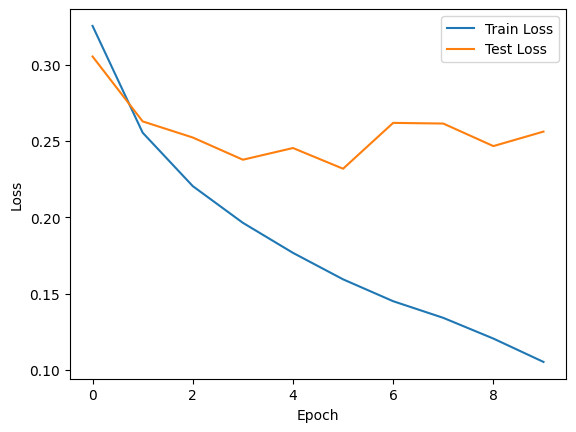

In [8]:
plt.plot(train_losses_list, label='Train Loss')
plt.plot(test_losses_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

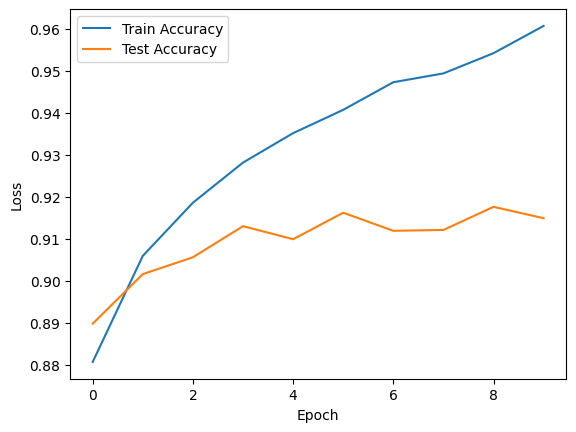

In [9]:
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualization Function

In [37]:
# Visualization
def personal_pca(X, n_components):
    # 数据矩阵X的均值归零化
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # 计算协方差矩阵的特征值和特征向量
    cov_matrix = np.dot(X_centered.T, X_centered)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # 对特征值进行排序
    eigenvectors = eigenvectors[:, np.argsort(-eigenvalues)]
    eigenvalues = eigenvalues[np.argsort(-eigenvalues)]

    # 选择前n个特征向量
    selected_eigenvectors = eigenvectors[:, :n_components]

    # 对原始数据进行降维
    transformed = np.dot(X_centered, selected_eigenvectors)

    return transformed

def personal_tsne(X, n_components, perplexity=30, learning_rate=200, n_iter=1000):
    def compute_pairwise_distances(X):
        sum_X = np.sum(np.square(X), axis=1)
        distances = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        return distances

    def compute_perplexity(distances, perplexity=30):
        P = np.zeros((X.shape[0], X.shape[0]))
        beta = np.ones(X.shape[0])
        for i in range(X.shape[0]):
            # 使用二分搜索找到合适的sigma值
            min_beta = None
            max_beta = float('inf')
            for _ in range(50):
                beta_i = beta[i]
                distances_i = distances[i, np.concatenate((np.r_[:i], np.r_[i + 1:X.shape[0]]))]
                probabilities = np.exp(-beta_i * distances_i)
                sum_probabilities = np.sum(probabilities)
                entropy = np.log(sum_probabilities) + beta_i * np.sum(distances_i * probabilities) / sum_probabilities
                entropy_diff = entropy - np.log(perplexity)
                if np.abs(entropy_diff) < 1e-5:
                    break
                if entropy_diff > 0:
                    min_beta = beta_i
                    if max_beta == float('inf'):
                        beta[i] *= 2
                    else:
                        beta[i] = (beta[i] + max_beta) / 2
                else:
                    max_beta = beta_i
                    if min_beta is None:
                        beta[i] /= 2
                    else:
                        beta[i] = (beta[i] + min_beta) / 2
            probabilities /= sum_probabilities
            P[i, np.concatenate((np.r_[:i], np.r_[i + 1:X.shape[0]]))] = probabilities
        return P

    def compute_gradient(P, Y):
        num = P.shape[0]
        PQ_diff = P - Q
        grad = np.zeros((num, n_components))
        for i in range(num):
            grad_i = np.tile(PQ_diff[i] * inv_distances[i], (n_components, 1)).T
            grad[i] = 4 * (grad_i * (Y[i] - Y)).sum(axis=0)
        return grad

    # 初始化Y
    Y = np.random.randn(X.shape[0], n_components)

    # 对称化数据
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # 计算欧氏距离的平方
    distances = compute_pairwise_distances(X)

    # 初始化P和Q
    P = compute_perplexity(distances, perplexity)
    P = P + P.T
    P = P / np.sum(P)
    P = P * 4  # early exaggeration
    P = np.maximum(P, 1e-12)

    for iter in range(n_iter):
        # 计算Q
        inv_distances = 1 / (1 + distances)
        np.fill_diagonal(inv_distances, 0)
        Q = inv_distances / np.sum(inv_distances)
        Q = np.maximum(Q, 1e-12)

        # 计算梯度
        dY = compute_gradient(P, Y)

        # 更新Y
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < 0.01] = 0.01
        iY = learning_rate * gains * dY
        Y = Y - iY

        # 归一化Y
        Y = Y - np.mean(Y, axis=0)

        # 打印迭代进度
        if (iter + 1) % 100 == 0:
            error = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter + 1}: error = {error}")

    return Y

## 2D Visualization

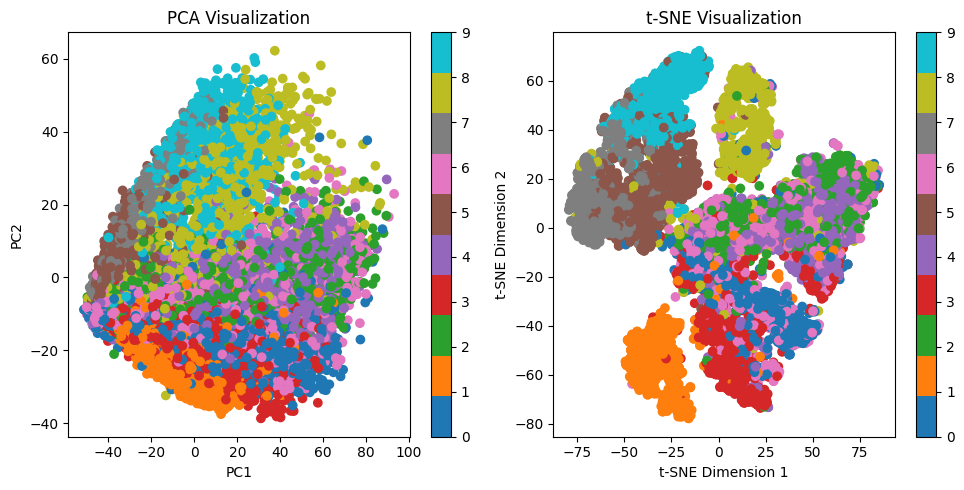

In [38]:
# 使用PCA降维
pca = PCA(n_components=2)
pca_features = pca.fit_transform(all_features)

# 使用t-SNE降维
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(all_features)

# 绘制PCA降维结果的散点图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=all_labels, cmap='tab10')
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

# 绘制t-SNE降维结果的散点图
plt.subplot(1, 2, 2)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=all_labels, cmap='tab10')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3D Visualization

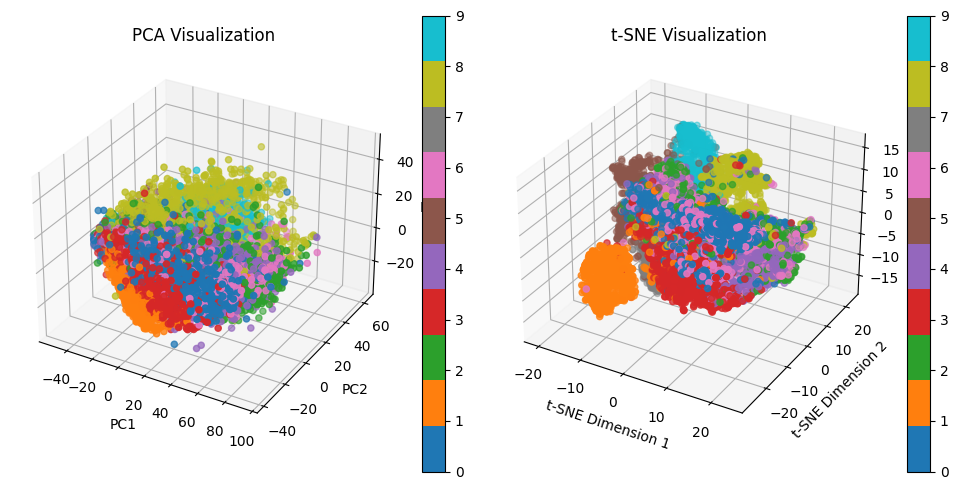

In [39]:
# 使用PCA降维
pca = PCA(n_components=3)
pca_features = pca.fit_transform(all_features)

# 使用t-SNE降维
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(all_features)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# 绘制PCA降维结果的散点图
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=all_labels, cmap='tab10')
ax1.set_title('PCA Visualization')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
fig.colorbar(scatter1, ax=ax1)

# 绘制t-SNE降维结果的散点图
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(tsne_features[:, 0], tsne_features[:, 1], tsne_features[:, 2], c=all_labels, cmap='tab10')
ax2.set_title('t-SNE Visualization')
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_zlabel('t-SNE Dimension 3')
fig.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()